### Signal Classification and Feature Extraction Using RML2016.10a Dataset

#### Dataset Overview

The dataset used is **RML2016.10a**. It contains modulated signals with varying Signal-to-Noise Ratios (SNR) and modulation types, represented as keys in a dictionary format.

- **Keys**: (Modulation type, SNR)
- **Signal Data**: Each key maps to a NumPy array of signal samples, with shape `(num_samples, 2, 128)` representing in-phase (I) and quadrature (Q) components.
### Summary of Actions in the Notebook

#### Dataset Exploration
- Inspected the **RML2016.10a** dataset structure.
- Visualized I/Q signal components for sample signals.

#### Approach 1: Raw Signal Classification
- Filtered signals with `SNR == 18`.
- Preprocessed raw signals to shape `(num_samples, 128, 2)` for 1D-CNN.
- Defined and trained a 1D-CNN with three convolutional layers.
- Achieved test accuracy of **~75-77%**.
- Experimented with adding four additional features (e.g., mean amplitude), which reduced test accuracy to **68%**.

#### Approach 2: Feature-Based Classification
- Extracted 15+ features, including:
  - **Time-domain features**: Amplitude envelope, signal energy, zero-crossing rate.
  - **Frequency-domain features**: Dominant frequency, spectral entropy, bandwidth.
  - **Phase-domain features**: Instantaneous phase, phase transitions.
  - **Statistical features**: Mean, variance, skewness, kurtosis.
  - **Constellation features**: Constellation points, inter-point distances.
- Mapped signals to feature vectors.
- Evaluated classification performance using a Random Forest Classifier.

#### Key Results
- Raw signal classification using a 1D-CNN achieved high accuracy, while adding features disrupted performance.
- Feature-based classification provided interpretable insights with competitive results using a simpler model.

## Approach 1: Raw Signal Classification with 1D-CNN

### Steps Taken

1. **Data Exploration**:
   - Inspected dataset structure and key-value pairs.
   - Visualized I/Q signal components for a sample.

2. **Data Preparation**:
   - Filtered clean signals (`SNR == 18`).
   - Transformed raw signals into a shape compatible with 1D-CNN: `(num_samples, 128, 2)`.

3. **Model Definition**:
   - A 1D-CNN with three convolutional layers, batch normalization, pooling, and dropout.
   - Fully connected layers with softmax activation for 11-class classification.

4. **Training and Evaluation**:
   - Trained for 30 epochs with a batch size of 64.
   - Test accuracy achieved: **~75-77%**.

5. **Adding Additional Features**:
   - Extracted 4 features:
     - Mean amplitude
     - Standard deviation of amplitude
     - Dominant frequency
     - Mean phase difference
   - Concatenated features to raw signal data.
   - Test accuracy decreased 68%, suggesting added features disrupted the model's ability to generalize.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, pairwise_distances
from scipy.signal import hilbert, find_peaks
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_pickle('RML2016.10a_dict.pkl')
#data

Key: ('QPSK', 2), Type: <class 'numpy.ndarray'>
Key: ('PAM4', 8), Type: <class 'numpy.ndarray'>
Key: ('AM-DSB', -4), Type: <class 'numpy.ndarray'>
Key: ('GFSK', 6), Type: <class 'numpy.ndarray'>
Key: ('QAM64', 8), Type: <class 'numpy.ndarray'>
Key: ('AM-SSB', 12), Type: <class 'numpy.ndarray'>
Key: ('8PSK', 8), Type: <class 'numpy.ndarray'>
Key: ('8PSK', 12), Type: <class 'numpy.ndarray'>
Key: ('QAM64', -6), Type: <class 'numpy.ndarray'>
Key: ('QAM16', 2), Type: <class 'numpy.ndarray'>
Key: ('QAM16', -20), Type: <class 'numpy.ndarray'>
Key: ('PAM4', -6), Type: <class 'numpy.ndarray'>
Key: ('WBFM', -18), Type: <class 'numpy.ndarray'>
Key: ('AM-DSB', 16), Type: <class 'numpy.ndarray'>
Key: ('CPFSK', 10), Type: <class 'numpy.ndarray'>
Key: ('WBFM', 6), Type: <class 'numpy.ndarray'>
Key: ('BPSK', 4), Type: <class 'numpy.ndarray'>
Key: ('BPSK', -2), Type: <class 'numpy.ndarray'>
Key: ('QPSK', -20), Type: <class 'numpy.ndarray'>
Key: ('CPFSK', -8), Type: <class 'numpy.ndarray'>
Key: ('AM-SSB

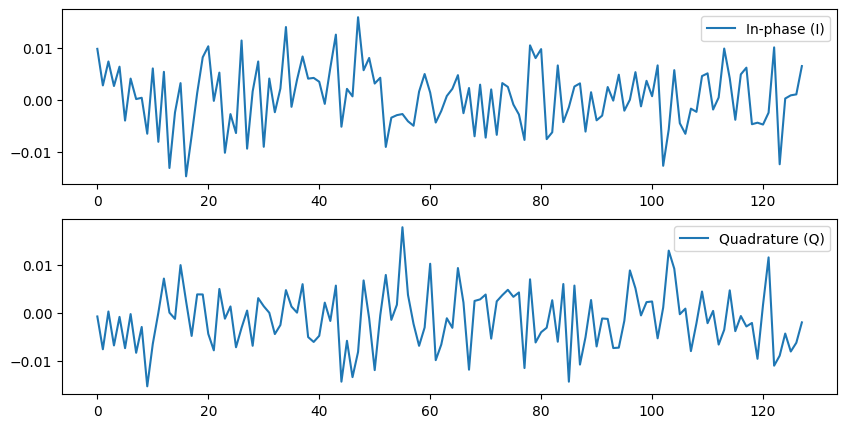

Keys: [('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4', 4

In [3]:
data.keys()
for key in data.keys():
    print(f"Key: {key}, Type: {type(data[key])}")

# Check the structure of a single key-value pair
for key, value in data.items():
    print(f"Key: {key}")
    print(f"Value Shape: {value.shape}")
    print(f"Value Type: {type(value)}")
    break  # Only inspect the first item


# Select a sample
key = ('WBFM', -12)  # Use an actual key from your data
signal = data[key][0]  # Select the first sample

# Plot the I and Q components
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(signal[0], label='In-phase (I)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(signal[1], label='Quadrature (Q)')
plt.legend()
plt.show()

# List all keys
print("Keys:", list(data.keys()))

# Analyze number of samples for each key
for key in data.keys():
    print(f"Key: {key}, Samples: {data[key].shape[0]}")

# Signal statistics
mean_i = np.mean(signal[0])
mean_q = np.mean(signal[1])
std_i = np.std(signal[0])
std_q = np.std(signal[1])

print(f"Mean I: {mean_i}, Std I: {std_i}")
print(f"Mean Q: {mean_q}, Std Q: {std_q}")

# Group statistics by key
for key, samples in data.items():
    mean_i = np.mean(samples[:, 0, :])  # Mean of I across all samples
    mean_q = np.mean(samples[:, 1, :])  # Mean of Q across all samples
    print(f"Key: {key}, Mean I: {mean_i:.3f}, Mean Q: {mean_q:.3f}")

In [4]:
snr_list=[]
for key, samples in data.items():
    _, snr = key  # Key is a tuple: (modulation, SNR)
    snr_list.append(snr)
    

In [5]:
np.unique(snr_list) # This shows the unique signal-noise ratio we have in the dataset

array([-20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,
         6,   8,  10,  12,  14,  16,  18])

In [6]:

only_clean_signal = True # Whether we focus on snr == 0 (clean data) or not 

# Define a mapping from modulation type to class label (0 to 10 for 11 classes) 
# This is because we have 11 classes and the classifier accepts integers as labels of different classes not strings.
modulation_classes = {
    'BPSK': 0, 'QPSK': 1, '8PSK': 2, 'PAM4': 3, 'CPFSK': 4, 
    'GFSK': 5, 'QAM16': 6, 'QAM64': 7, 'AM-DSB': 8, 'AM-SSB': 9, 'WBFM': 10
}

# Containers for features and labels

# We first save the training data X as a list in features. The numpy format of such list has the shape of (220,1000,2,128) 
# Then we use the np.vstack of the features which has the shape of (220000,2,128)
# Finally we use tf.convert_to_tensor to make it suitable for tensorflow.

features = []
labels = []

# Transform dictionary to features and labels
for key, samples in data.items():
    modulation, snr = key  # Key is a tuple: (modulation, SNR)
    label = modulation_classes[modulation]  # Map modulation to label
    if only_clean_signal:
        if snr == 0:
            features.append(samples)  # Add the feature data
            labels.extend([label] * samples.shape[0])  # Repeat label for all samples in this key
    else:
        features.append(samples)  # Add the feature data
        labels.extend([label] * samples.shape[0])  # Repeat label for all samples in this key

# Stack all features and convert labels to tensors
#X = tf.convert_to_tensor(np.vstack(features), dtype=tf.float32)  # Shape: (num_samples, 2, 128)
#y = tf.convert_to_tensor(np.array(labels), dtype=tf.int32)       # Shape: (num_samples,)
X=np.vstack(features)
y=np.array(labels)
# The format of the target we use, deponds on the loss function. For loss='sparse_categorical_crossentropy', the target can be different integers (like y), but we can use loss = categorical_crossentropy, then use y_one_hot
#y_one_hot = tf.keras.utils.to_categorical(y, num_classes=11)



In [7]:
features

[array([[[ 0.00640221,  0.00113712,  0.00393576, ..., -0.00193549,
          -0.00847488, -0.00525571],
         [-0.00398697, -0.00559275, -0.00575361, ..., -0.00156517,
           0.00256058,  0.00055502]],
 
        [[-0.00892831, -0.0012138 ,  0.00097897, ..., -0.00411613,
          -0.00618693, -0.00299957],
         [-0.00556639, -0.00951133, -0.0114527 , ...,  0.00145869,
           0.00511539,  0.00342825]],
 
        [[-0.00630913, -0.00240987, -0.00775012, ...,  0.00173789,
           0.00144398,  0.00484569],
         [-0.00493511, -0.00451366, -0.00053267, ...,  0.00218305,
           0.00484666,  0.01302766]],
 
        ...,
 
        [[-0.00359306, -0.00395127, -0.00386439, ...,  0.00947887,
           0.00944446,  0.0082365 ],
         [-0.0035182 , -0.00926572, -0.00544853, ..., -0.00011293,
          -0.00150252, -0.00401832]],
 
        [[-0.00922128, -0.0120894 , -0.00249494, ..., -0.00114427,
           0.00021922, -0.00279841],
         [ 0.00299887,  0.00504536, -

In [8]:
np.array(features).shape,np.vstack(features).shape, np.array(labels).shape

((11, 1000, 2, 128), (11000, 2, 128), (11000,))

In [9]:
y

array([4, 4, 4, ..., 8, 8, 8])

In [10]:
# Ensure features have the correct shape for Conv1D
X_np = np.transpose(X, (0, 2, 1))  # Convert TensorFlow tensor to NumPy and transpose
#y_np = y.numpy()  # Convert labels to NumPy array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y, test_size=0.2, random_state=42)

# Define the model

# Here we define the model that includes 3 hidden layers. Conv1D is used for sequential data. We could also used LSTM or RNN in general. the pooling and kernel goes through the sequence and capture the sequential format.

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 2)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')  # 11 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse labels (integer targets)
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3415 - loss: 1.8122 - val_accuracy: 0.0927 - val_loss: 2.5192
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5792 - loss: 1.0197 - val_accuracy: 0.0927 - val_loss: 2.7746
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6768 - loss: 0.7805 - val_accuracy: 0.0932 - val_loss: 3.6376
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7203 - loss: 0.6715 - val_accuracy: 0.1827 - val_loss: 3.9542
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7627 - loss: 0.5808 - val_accuracy: 0.4155 - val_loss: 1.5529
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7780 - loss: 0.5339 - val_accuracy: 0.5686 - val_loss: 1.1329
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8027 - loss: 0.4721 - val_accuracy: 0.6632 - val_loss: 0.7948
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8381 - loss: 0.3953 - val_accu

## Adding Features

In [11]:
only_clean_signal = True  # Whether we focus on snr == 0 (clean data) or not 

# Define a mapping from modulation type to class label (0 to 10 for 11 classes)
modulation_classes = {
    'BPSK': 0, 'QPSK': 1, '8PSK': 2, 'PAM4': 3, 'CPFSK': 4, 
    'GFSK': 5, 'QAM16': 6, 'QAM64': 7, 'AM-DSB': 8, 'AM-SSB': 9, 'WBFM': 10
}

# Containers for features and labels
original_features = []
additional_features = []
labels = []

# Function to extract 4 additional features
def extract_features(signal, sampling_rate=1.0):
    import numpy as np
    from scipy.fft import fft, fftfreq

    # Extract I and Q components
    I, Q = signal[0], signal[1]
    complex_signal = I + 1j * Q

    # Amplitude envelope (magnitude of the complex signal)
    amplitude_envelope = np.abs(complex_signal)

    # Dominant frequency
    fft_result = fft(complex_signal)
    freqs = fftfreq(len(complex_signal), d=1 / sampling_rate)
    dominant_freq = freqs[np.argmax(np.abs(fft_result))]

    # Phase difference
    phase_difference = np.angle(complex_signal)

    # Return features
    return {
        "mean_amplitude": np.mean(amplitude_envelope),
        "std_amplitude": np.std(amplitude_envelope),
        "dominant_frequency": dominant_freq,
        "mean_phase_difference": np.mean(phase_difference)
    }

# Transform dictionary to features and labels
for key, samples in data.items():
    modulation, snr = key  # Key is a tuple: (modulation, SNR)
    label = modulation_classes[modulation]  # Map modulation to label
    if only_clean_signal and snr != 0:
        continue

    # Extract features
    for signal in samples:
        original_features.append(signal)  # Add the original feature data
        extracted_features = extract_features(signal)  # Extract 4 additional features
        additional_features.append([
            extracted_features["mean_amplitude"],
            extracted_features["std_amplitude"],
            extracted_features["dominant_frequency"],
            extracted_features["mean_phase_difference"]
        ])
        labels.append(label)  # Append the label for each sample

# Convert original features and additional features to NumPy arrays
original_features = np.array(original_features)  # Shape: (num_samples, 2, 128)
additional_features = np.array(additional_features)  # Shape: (num_samples, 4)
labels = np.array(labels)

# Transpose original features to match Conv1D input shape
original_features = np.transpose(original_features, (0, 2, 1))  # Shape: (num_samples, 128, 2)

# Repeat additional features along the time dimension to match the original features
additional_features_repeated = np.repeat(additional_features[:, np.newaxis, :], original_features.shape[1], axis=1)

# Concatenate original features with additional features
X_combined = np.concatenate([original_features, additional_features_repeated], axis=-1)  # Shape: (num_samples, 128, 6)

# Convert labels to one-hot encoding if needed
y_one_hot = tf.keras.utils.to_categorical(labels, num_classes=11)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)


In [12]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 6)),  # Updated input shape
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')  # 11 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse labels (integer targets)
    metrics=['accuracy']
)

# Split the combined data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2046 - loss: 3.5047 - val_accuracy: 0.1173 - val_loss: 2.3424
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2277 - loss: 2.5313 - val_accuracy: 0.1255 - val_loss: 2.2779
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2336 - loss: 2.2234 - val_accuracy: 0.2259 - val_loss: 2.0380
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2581 - loss: 2.0198 - val_accuracy: 0.2891 - val_loss: 1.9308
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2811 - loss: 1.8714 - val_accuracy: 0.3209 - val_loss: 1.7382
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3106 - loss: 1.7483 - val_accuracy: 0.3336 - val_loss: 1.6133
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3631 - loss: 1.6504 - val_accuracy: 0.4491 - val_loss: 1.4401
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3990 - loss: 1.5065 - val_accu

## Key Findings

- **Raw Signal Classification (Approach 1)**:
  - 1D-CNN effectively learned signal patterns directly from raw I/Q data.
  - Adding basic features reduced accuracy, indicating interference with the model's learned representations.
  --------------------

## Approach 2: Feature Extraction-Based Classification

### Motivation

In this approach, we examined whether feature engineering could enhance signal classification by capturing key characteristics of modulation schemes.

### Features Extracted

#### 1. **Time-Domain Features**
   - **Amplitude Envelope**: Magnitude over time.
   - **Signal Energy (RMS)**: Average power.
   - **Zero-Crossing Rate**: Frequency of zero crossings.
   - **Autocorrelation**: Periodicity detection.

#### 2. **Frequency-Domain Features**
   - **Dominant Frequency**: Peak power frequency.
   - **Bandwidth**: Frequency range with 90% power.
   - **Spectral Entropy**: Complexity of frequency distribution.
   - **Harmonic Content**: Analysis of harmonics.

#### 3. **Phase-Domain Features**
   - **Instantaneous Phase**: Phase at each time step.
   - **Phase Transitions**: Count of abrupt changes.
   - **Phase Continuity**: Smooth vs. abrupt transitions.

#### 4. **Statistical Features**
   - **Mean/Variance**: Amplitude and phase characteristics.
   - **Skewness/Kurtosis**: Distribution shapes.
   - **Symbol Rate**: Symbols per second.

#### 5. **Constellation Features**
   - **Constellation Points**: Unique points in amplitude-phase plane.
   - **Point Distances**: Average inter-point distance.

#### 6. **Cross-Domain Features**
   - Time-Frequency representations (e.g., STFT, wavelet transforms).

### Implementation

1. **Feature Engineering**:
   - Developed an extraction function to calculate 15+ features.
   - Mapped signals into a feature vector representation.

2. **Classifier**:
   - Random Forest Classifier was used to evaluate feature-based classification.

3. **Evaluation**:
   - Test accuracy: **~81%**.

In [13]:
data= pd.read_pickle('RML2016.10a_dict.pkl')
#data

In [14]:
signal_data = data[('AM-DSB', 0)]
# Example usage
features = extract_features(signal_data[0])  # First signal from the key
print(features)

{'mean_amplitude': 0.0078125, 'std_amplitude': 0.0036291345, 'dominant_frequency': 0.0, 'mean_phase_difference': -1.4418366}


In [15]:
def extract_features(signal, sampling_rate=1.0):
    """
    Extracts features from a given signal.
    
    Parameters:
    - signal: A single signal sample with shape (2, 128) (In-phase and Quadrature components).
    - sampling_rate: Sampling rate of the signal.

    Returns:
    - A dictionary containing all extracted features.
    """
    I, Q = signal[0], signal[1]
    complex_signal = I + 1j * Q

    # --- Time-Domain Features ---
    amplitude_envelope = np.abs(complex_signal)  # Amplitude envelope
    zero_crossings = np.sum(np.diff(np.sign(I)) != 0)  # Zero-crossing rate
    signal_energy = np.sqrt(np.mean(I**2 + Q**2))  # RMS energy
    autocorr = np.correlate(amplitude_envelope, amplitude_envelope, mode='full')[len(amplitude_envelope)-1]

    # --- Frequency-Domain Features ---
    fft_result = fft(complex_signal)
    freqs = fftfreq(len(complex_signal), d=1/sampling_rate)
    dominant_freq = freqs[np.argmax(np.abs(fft_result))]  # Dominant frequency
    bandwidth = np.sum(np.abs(fft_result) > (0.9 * np.max(np.abs(fft_result))))  # Bandwidth
    spectral_entropy = -np.sum((np.abs(fft_result)**2 / np.sum(np.abs(fft_result)**2)) * 
                               np.log2(np.abs(fft_result)**2 / np.sum(np.abs(fft_result)**2) + 1e-12))  # Entropy

    # --- Phase-Domain Features ---
    instantaneous_phase = np.angle(complex_signal)  # Phase
    phase_transitions = np.sum(np.abs(np.diff(instantaneous_phase)) > np.pi / 4)  # Phase transitions
    mean_phase_difference = np.mean(np.diff(instantaneous_phase))  # Phase difference

    # --- Statistical Features ---
    mean_amplitude = np.mean(amplitude_envelope)
    std_amplitude = np.std(amplitude_envelope)
    skewness_amplitude = np.mean((amplitude_envelope - mean_amplitude)**3) / (std_amplitude**3 + 1e-12)
    kurtosis_amplitude = np.mean((amplitude_envelope - mean_amplitude)**4) / (std_amplitude**4 + 1e-12)
    symbol_rate = 1 / (np.mean(np.diff(np.nonzero(np.diff(np.sign(I)))[0])) + 1e-12)  # Approximate symbol rate

    # --- Constellation Features ---
    constellation_points = np.column_stack((I, Q))  # Combine I and Q
    unique_points = np.unique(np.round(constellation_points, decimals=2), axis=0)  # Approximation for unique points
    num_constellation_points = unique_points.shape[0]
    avg_distance_between_points = np.mean(pairwise_distances(constellation_points))

    # Combine all features
    features = {
        # Time-Domain
        "amplitude_envelope_mean": mean_amplitude,
        "amplitude_envelope_std": std_amplitude,
        "zero_crossings": zero_crossings,
        "signal_energy": signal_energy,
        "autocorrelation": autocorr,
        
        # Frequency-Domain
        "dominant_frequency": dominant_freq,
        "bandwidth": bandwidth,
        "spectral_entropy": spectral_entropy,
        
        # Phase-Domain
        "phase_transitions": phase_transitions,
        "mean_phase_difference": mean_phase_difference,
        
        # Statistical
        "skewness_amplitude": skewness_amplitude,
        "kurtosis_amplitude": kurtosis_amplitude,
        "symbol_rate": symbol_rate,
        
        # Constellation Features
        "num_constellation_points": num_constellation_points,
        "avg_distance_between_points": avg_distance_between_points,
    }
    
    return features

In [16]:
modulation_classes = {
    'BPSK': 0,      # Binary Phase Shift Keying
    'QPSK': 1,      # Quadrature Phase Shift Keying
    '8PSK': 2,      # 8-level Phase Shift Keying
    'PAM4': 3,      # 4-level Pulse Amplitude Modulation
    'CPFSK': 4,     # Continuous Phase Frequency Shift Keying
    'GFSK': 5,      # Gaussian Frequency Shift Keying
    'QAM16': 6,     # 16-level Quadrature Amplitude Modulation
    'QAM64': 7,     # 64-level Quadrature Amplitude Modulation
    'AM-DSB': 8,    # Amplitude Modulation - Double Side Band
    'AM-SSB': 9,    # Amplitude Modulation - Single Side Band
    'WBFM': 10      # Wideband Frequency Modulation
}

In [17]:
features_list = []
labels = []

for key, samples in data.items():
    modulation, snr = key
    label = modulation_classes[modulation]
    if snr == 18:
        for signal in samples:
            features = extract_features(signal)
            features["label"] = label  # Add label for each signal
            features_list.append(features)

# Convert features to a structured format
features_df = pd.DataFrame(features_list)


In [18]:
features_df

,amplitude_envelope_mean,amplitude_envelope_std,zero_crossings,signal_energy,autocorrelation,dominant_frequency,bandwidth,spectral_entropy,phase_transitions,mean_phase_difference,skewness_amplitude,kurtosis_amplitude,symbol_rate,num_constellation_points,avg_distance_between_points,label
0,0.007812,0.000424,2,0.007824,0.007835,-0.007812,1,2.668851,3,-0.037497,-0.266268,0.050515,0.018868,5,0.008366,5
1,0.007812,0.000357,1,0.007821,0.007829,0.000000,1,1.804143,2,0.011751,-0.352729,0.030492,NaN,4,0.004768,5
2,0.007812,0.000296,1,0.007818,0.007824,0.000000,1,2.838641,0,0.025069,-0.401021,0.014531,NaN,5,0.007335,5
3,0.007812,0.000373,2,0.007821,0.007830,0.000000,1,1.960890,0,0.001343,-0.110334,0.027408,0.055556,3,0.005574,5
4,0.007812,0.000372,5,0.007821,0.007830,0.000000,1,2.084887,0,-0.007038,0.021588,0.027388,0.035714,5,0.005585,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,0.007812,0.002248,13,0.008130,0.008459,0.015625,4,4.006192,7,0.025089,-0.991123,3.804141,0.100000,6,0.010127,1
10996,0.007812,0.002019,10,0.008069,0.008334,-0.031250,1,4.001219,12,0.039159,-1.379473,4.563561,0.086538,8,0.010069,1
10997,0.007812,0.002399,10,0.008173,0.008549,-0.031250,2,3.882808,8,-0.036426,-0.939422,3.800272,0.082569,7,0.009996,1
10998,0.007813,0.002236,12,0.008126,0.008453,0.039062,1,3.437435,10,-0.006684,-1.095620,3.856770,0.094017,9,0.010127,1


In [19]:
# Assuming features_df is ready
# Features (X) and labels (y)
X = features_df.drop(columns=['label']).values  # Drop the label column to use the rest as features
y = features_df['label'].values  # Labels (target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,    
    max_depth=20,      
    random_state=42,
)

# Train the classifier
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.69      0.72      0.71       200
           2       0.69      0.64      0.66       200
           3       0.96      0.95      0.96       200
           4       1.00      1.00      1.00       200
           5       0.98      0.99      0.98       200
           6       0.65      0.64      0.64       200
           7       0.67      0.67      0.67       200
           8       0.66      0.89      0.76       200
           9       0.94      0.99      0.97       200
          10       0.81      0.51      0.63       200

    accuracy                           0.81      2200
   macro avg       0.82      0.81      0.81      2200
weighted avg       0.82      0.81      0.81      2200

Test Accuracy: 0.81


## Key Findings

- **Feature-Based Classification (Approach 2)**:
  - Hand-crafted features provided interpretable and meaningful insights into signal behavior.
  - Achieved robust and good accuracy (~81%) using a simpler Random Forest model, demonstrating the effectiveness of feature engineering.

---

## Conclusion

- **Trade-offs**:
  - Raw signal classification using 1D-CNN is powerful, achieving ~75-77% accuracy, but requires careful preprocessing and is less interpretable.
  - Feature-based methods offer interpretability and achieved good performance (~81%) but may face challenges with highly complex patterns.
